In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
transforms = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = datasets.CIFAR10(root='./DataSet/CIFAR10', train=True, download=True, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [5]:
latent_dim = 100
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
epochs = 10

In [6]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
			nn.Linear(latent_dim, 128*8*8),
			nn.ReLU(),

			nn.Unflatten(1, (128, 8, 8)),

			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.ReLU(),

			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.ReLU(),

			nn.Conv2d(64, 32, kernel_size=3, padding=1),
			nn.ReLU(),

			nn.Conv2d(32, 3, kernel_size=3, padding=1),
			nn.Tanh()
		)
        
    def forward(self, z):
        img = self.model(z)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
			nn.LeakyReLU(0.2),
			nn.Dropout(0.25),

			nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
			nn.ZeroPad2d((0, 1, 0, 1)),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.LeakyReLU(0.2),
			nn.Dropout(0.25),

			nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.LeakyReLU(0.2),
			nn.Dropout(0.25),

			nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
			nn.BatchNorm2d(256, momentum=0.78),	
			nn.LeakyReLU(0.2),
			nn.Dropout(0.25),

			nn.Flatten(),
			nn.Linear(256*5*5, 1),
			nn.Sigmoid()
		)

    def forward(self, img):
        validity = self.model(img)
        return validity

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterian = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

Epoch [1/10]                Batch 1563/1563 Discriminator Loss: 0.9352 Generator Loss: 0.7334
Epoch [2/10]                Batch 1563/1563 Discriminator Loss: 0.7871 Generator Loss: 0.5718
Epoch [3/10]                Batch 1563/1563 Discriminator Loss: 0.6739 Generator Loss: 1.5274
Epoch [4/10]                Batch 1563/1563 Discriminator Loss: 0.6422 Generator Loss: 1.2466
Epoch [5/10]                Batch 1563/1563 Discriminator Loss: 0.5394 Generator Loss: 1.3019
Epoch [6/10]                Batch 1563/1563 Discriminator Loss: 0.4260 Generator Loss: 1.2221
Epoch [7/10]                Batch 1563/1563 Discriminator Loss: 0.4118 Generator Loss: 1.1419
Epoch [8/10]                Batch 1563/1563 Discriminator Loss: 0.6222 Generator Loss: 0.9067
Epoch [9/10]                Batch 1563/1563 Discriminator Loss: 0.8804 Generator Loss: 0.9637
Epoch [10/10]                Batch 1563/1563 Discriminator Loss: 0.6382 Generator Loss: 0.7213


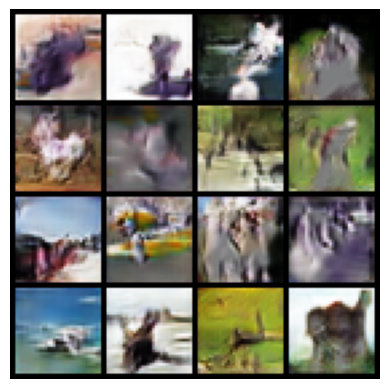

In [10]:
for epoch in range(epochs):
    
    for i, (img_batch, _) in enumerate(train_loader):
        
        real_imgs = img_batch.to(device)
        
        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)
        
        real_images = real_imgs.to(device)
        
        
        # discriminator update
        optimizer_D.zero_grad()
        
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        
        fake_images = generator(z)
        
        real_img_output = discriminator(real_images)
        fake_img_output = discriminator(fake_images.detach())
        
        real_img_loss = criterian(real_img_output, valid)
        fake_img_loss = criterian(fake_img_output, fake)
        
        total_loss = (real_img_loss + fake_img_loss) / 2
        
        total_loss.backward()
        optimizer_D.step()
        
        
        # generator update
        generator.zero_grad()
        
        generator_output = generator(z)
        
        discriminator_output = discriminator(generator_output)
        
        g_loss = criterian(discriminator_output, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        
        # if (i + 1) % 100 == 0:
    print(
        f"Epoch [{epoch+1}/{epochs}]\
                Batch {i+1}/{len(train_loader)} "
        f"Discriminator Loss: {total_loss.item():.4f} "
        f"Generator Loss: {g_loss.item():.4f}"
    )
        
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()